In [1]:
### constantes do problema
## 2 => ( 0 - pulmao normal | 1 - pulmao com pneumonia)
numero_classes = 2

## dimensao da imagem
# tamanho x tamanho
tamanho = 100
profundidade = 3

# tamanho do batch
batch = 2000

# numero de epocas
epoch = 25

# divisao do dataset
teste  = 0.25
treino = 0.75

## caminhos das pastas das imagens 
caminho_test_normal     = "/home/pedro/Imagens/processado_chest-xray-pneumonia/test/NORMAL/*.png"
caminho_test_pneumonia  = "/home/pedro/Imagens/processado_chest-xray-pneumonia/test/PNEUMONIA/*.png"

caminho_train_normal    = "/home/pedro/Imagens/processado_chest-xray-pneumonia/train/NORMAL/*.png" 
caminho_train_pneumonia = "/home/pedro/Imagens/processado_chest-xray-pneumonia/train/PNEUMONIA/*.png"

caminho_val_normal      = "/home/pedro/Imagens/processado_chest-xray-pneumonia/val/NORMAL/*.png"
caminho_val_pneumonia   = "/home/pedro/Imagens/processado_chest-xray-pneumonia/val/PNEUMONIA/*.png"

In [2]:
import numpy as np
import keras
import cv2 
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

import matplotlib.pyplot as plt

from modelo import model

Using TensorFlow backend.


In [3]:
### funcao para carregar a imagem do caminho

def ler_imagem(caminho):
    img = cv2.imread(caminho)
    imres = image.img_to_array(img)
    imres = np.expand_dims(imres, axis = 0)    
    return imres

In [4]:
### carrega o dataset para a memoria

import glob

arquivo_test_normal    = glob.glob(caminho_test_normal)
arquivo_test_pneumonia = glob.glob(caminho_test_pneumonia)

arquivo_train_normal    = glob.glob(caminho_train_normal)
arquivo_train_pneumonia = glob.glob(caminho_train_pneumonia)

arquivo_val_normal    = glob.glob(caminho_val_normal)
arquivo_val_pneumonia = glob.glob(caminho_val_pneumonia)


## busca cada imagem e salva em arrays

# dados de teste normais
test_normal = []
for caminho_imagem in arquivo_test_normal:
    test_normal.append(ler_imagem(caminho_imagem))
    
# dados de teste com pneumonia
test_pneumonia =  []
for caminho_imagem in arquivo_test_pneumonia:
    test_pneumonia.append(ler_imagem(caminho_imagem))
    
# dados de treino normais
train_normal =  []
for caminho_imagem in arquivo_train_normal:
    train_normal.append(ler_imagem(caminho_imagem))
    
# dados de teste pneumonia
train_pneumonia =  []
for caminho_imagem in arquivo_train_pneumonia:
    train_pneumonia.append(ler_imagem(caminho_imagem))

# dados de validacao normais
val_normal =  []
for caminho_imagem in arquivo_val_normal:
    val_normal.append(ler_imagem(caminho_imagem))
    
# dados de validacao pneumonia
val_pneumonia =  []
for caminho_imagem in arquivo_val_pneumonia:
    val_pneumonia.append(ler_imagem(caminho_imagem))
    

In [5]:
### cria o Y do dataset
## 0 -> pulmao normal    1 -> pulmao com pneumonia
y_test = np.concatenate( 
    (
        np.array( [0] * len(arquivo_test_normal)    ) , 
        np.array( [1] * len(arquivo_test_pneumonia) ) 
    ),
    axis = 0 )

y_train = np.concatenate( 
    (
        np.array( [0] * len(arquivo_train_normal)    ) , 
        np.array( [1] * len(arquivo_train_pneumonia) ) ,
        np.array( [0] * len(arquivo_val_normal)      ) , 
        np.array( [1] * len(arquivo_val_pneumonia)   ) 
    ),
    axis = 0 )

In [6]:
### concatena todo o dataset

x_test = np.concatenate( 
    (
        test_normal, 
        test_pneumonia 
    ),
    axis = 0
)
x_test = np.array(x_test, dtype="float") / 255.0

x_train = np.concatenate( 
    (
        train_normal, 
        train_pneumonia,
        val_normal, 
        val_pneumonia 
    ),
    axis = 0 )
x_train = np.array(x_train, dtype="float") / 255.0
    


# libera memoria
del train_normal    
del train_pneumonia 
del test_normal     
del test_pneumonia  
del val_normal      
del val_pneumonia   

In [7]:
### misturar os dados X e Y

from sklearn.utils import shuffle
x_test  , y_test  = shuffle(x_test  , y_test)
x_train , y_train = shuffle(x_train , y_train)
  
# rearranja os dados

x_train = x_train.reshape(len(x_train),profundidade,tamanho,tamanho)
x_test  = x_test.reshape(len(x_test),profundidade,tamanho,tamanho)

print(x_test.shape)
print(x_train.shape)

(624, 3, 100, 100)
(5232, 3, 100, 100)


In [9]:
### categoriza os Y


y_test  = keras.utils.to_categorical(y_test , numero_classes)
y_train = keras.utils.to_categorical(y_train, numero_classes)


In [10]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(5232, 3, 100, 100)
(5232, 2)
(624, 3, 100, 100)
(624, 2)


In [11]:
## cria o modelo

modelo = model(
    tamanho = tamanho,
    profundidade = profundidade,
    numero_classes = numero_classes
)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
## compilacao da cnn
modelo.compile(
    optimizer          = keras.optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False), 
    loss               = "categorical_crossentropy", 
    metrics            = ['accuracy'], 
    loss_weights       = None, 
    sample_weight_mode = None, 
    weighted_metrics   = None, 
    target_tensors     = None
)

In [13]:
## cria callback para salvar o modelo a cada epoca finalizada
callback_save = ModelCheckpoint('/home/pedro/Documentos/modelo/xray.h5')

In [ ]:
## treinamento da cnn
history = modelo.fit(
    x                = x_train, 
    y                = y_train, 
    batch_size       = batch , 
    epochs           = epoch, 
    verbose          = 1, 
    callbacks        = [callback_save], 
    validation_split = 0.25, 
    validation_data  = None, 
    shuffle          = True, 
    class_weight     = None, 
    sample_weight    = None, 
    initial_epoch    = 0, 
    steps_per_epoch  = None, 
    validation_steps = None
)

Instructions for updating:
Use tf.cast instead.
Train on 3924 samples, validate on 1308 samples
Epoch 1/25
2000/3924 [==============>...............] - ETA: 47s - loss: 1.7337 - acc: 0.5085

In [14]:
## mostra resultado
score = modelo.evaluate(x_test, y_test, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

('Test loss:', 1.1370302515152173)
('Test accuracy:', 0.8221153846153846)


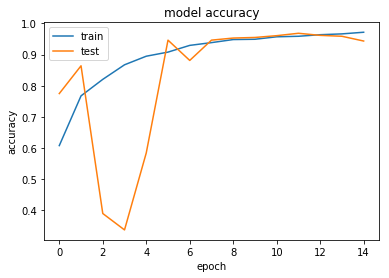

In [15]:
## plota resultado
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


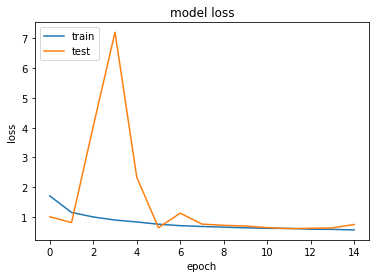

In [16]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()